In [35]:
import pandas as pd

# Load dataset
df = pd.read_excel(r"C:\Users\kfq6\Documents\Data\Sammedag_master_means_3m_2to4.xlsx")

# Basic info
print("Shape:", df.shape)
print("\n--- Column Overview ---")
print(df.info())

# Check for missing values
print("\n--- Missing Values ---")
print(df.isna().sum())

# Check unique patient IDs
ID_COL = "DW_EK_Borger"  # change if your ID column is named differently
print("\n--- Patient ID Check ---")
print(f"Unique IDs: {df[ID_COL].nunique()}")
print(f"Total rows: {len(df)}")

# Optionally, show duplicates if they exist
duplicates = df[df.duplicated(subset=[ID_COL], keep=False)]
if not duplicates.empty:
    print("\n--- Duplicate IDs ---")
    print(duplicates.sort_values(by=ID_COL))
else:
    print("\nNo duplicate patient IDs found.")

# --- Keep only patients with ≥2 rows (drop single-visit patients) ---
patient_counts = df.groupby(ID_COL).size()

multi_ids = patient_counts[patient_counts >= 2].index

print(f"\nKeeping only patients with ≥2 rows...")
print(f"Patients before filter: {patient_counts.shape[0]:,}")
print(f"Patients with ≥2 rows:  {len(multi_ids):,}")
print(f"Patients dropped (only 1 row): {(patient_counts.shape[0] - len(multi_ids)):,}")

# Overwrite df with multi-row cohort
df = df[df[ID_COL].isin(multi_ids)].copy()

print(f"\nFiltered dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Unique patients after filter: {df[ID_COL].nunique():,}")


Shape: (4168, 52)

--- Column Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4168 entries, 0 to 4167
Data columns (total 52 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   DW_EK_Borger                                  4168 non-null   int64         
 1   sex                                           4168 non-null   object        
 2   age                                           4168 non-null   float64       
 3   diabetes_type                                 4054 non-null   object        
 4   diagnosis                                     4168 non-null   object        
 5   comp_any                                      4168 non-null   int64         
 6   comp_eye                                      4168 non-null   int64         
 7   comp_renal                                    4168 non-null   int64         
 8   comp_neuro               

In [36]:
# --- Check if certain patient IDs (e.g. hospitalized patients) exist in the master dataset ---

# hospitalized patient IDs
hospitalized_ids = [143581, 443158, 461784, 700244, 998971, 1006451, 1082134, 1114165, 1220750 ,1233676, 1237827, 1268194]

# Convert to the same dtype as in df (important for matching)
hospitalized_ids = [int(x) for x in hospitalized_ids]
df[ID_COL] = df[ID_COL].astype(int)

# Check which IDs exist
existing_ids = df[df[ID_COL].isin(hospitalized_ids)][ID_COL].unique()
missing_ids  = [i for i in hospitalized_ids if i not in existing_ids]

print(f"Total hospitalized patients checked: {len(hospitalized_ids)}")
print(f"Found in master dataset: {len(existing_ids)}")
print(f"Missing from master dataset: {len(missing_ids)}")

if len(existing_ids) > 0:
    print("\nIDs found in dataset:")
    print(existing_ids)
if len(missing_ids) > 0:
    print("\nIDs missing from dataset:")
    print(missing_ids)

# Optional: subset only hospitalized patients if you need it for further analysis
df_hosp = df[df[ID_COL].isin(hospitalized_ids)].copy()
print(f"\nSubset of hospitalized patients: {df_hosp.shape[0]} rows from {df_hosp[ID_COL].nunique()} unique patients.")


Total hospitalized patients checked: 12
Found in master dataset: 0
Missing from master dataset: 12

IDs missing from dataset:
[143581, 443158, 461784, 700244, 998971, 1006451, 1082134, 1114165, 1220750, 1233676, 1237827, 1268194]

Subset of hospitalized patients: 0 rows from 0 unique patients.


In [37]:
comp_cols = [
    "comp_any", "comp_eye", "comp_renal", "comp_neuro",
    "comp_periph", "comp_foot", "comp_multiple",
    "comp_ketoac", "comp_coma", "comp_uns"
]


pd.unique(df[comp_cols].values.ravel())
df[comp_cols].stack().value_counts()

{col: df[col].value_counts() for col in comp_cols}



{'comp_any': comp_any
 0    2561
 1    1607
 Name: count, dtype: int64,
 'comp_eye': comp_eye
 0    3704
 1     464
 Name: count, dtype: int64,
 'comp_renal': comp_renal
 0    4081
 1      87
 Name: count, dtype: int64,
 'comp_neuro': comp_neuro
 0    4000
 1     168
 Name: count, dtype: int64,
 'comp_periph': comp_periph
 0    4082
 1      86
 Name: count, dtype: int64,
 'comp_foot': comp_foot
 0    4103
 1      65
 Name: count, dtype: int64,
 'comp_multiple': comp_multiple
 0    3833
 1     335
 Name: count, dtype: int64,
 'comp_ketoac': comp_ketoac
 0    4158
 1      10
 Name: count, dtype: int64,
 'comp_coma': comp_coma
 0    4166
 1       2
 Name: count, dtype: int64,
 'comp_uns': comp_uns
 0    3701
 1     467
 Name: count, dtype: int64}

In [38]:
import pandas as pd
import numpy as np

# ---------------------------
# Constants
# ---------------------------
ID_COL = "DW_EK_Borger"
DATE_COLS = ["anchor_date", "window_start", "window_end",
             "lab_window_start", "lab_window_end", "who_date"]
DIAG_COLS = ["diagnosis_y", "diagnosis_x"]  # prefer 'y' if present
LAB_PREFIX = "LABmean__"

# Ensure datetime
for c in DATE_COLS:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Collect lab columns
lab_cols = [c for c in df.columns if c.startswith(LAB_PREFIX)]
# Make sure lab cols are numeric
df[lab_cols] = df[lab_cols].apply(pd.to_numeric, errors="coerce")


Distribution of sammedagsscreening per patient:

2    701
3    862
4     45
Name: count, dtype: int64

Summary stats:
count    1608.000000
mean        2.592040
std         0.545604
min         2.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         4.000000
dtype: float64


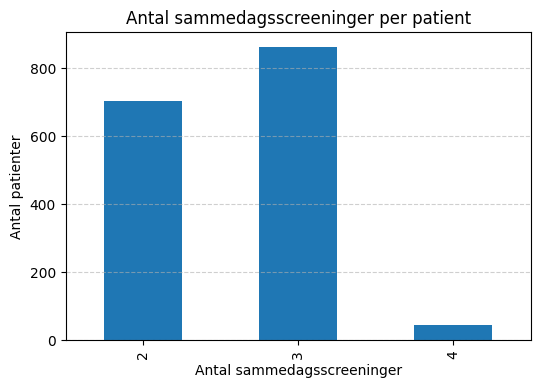

In [39]:
# --- Count sammedagsscreening per patient ---
screenings_per_patient = df.groupby(ID_COL).size()

# --- Basic stats ---
print("Distribution of sammedagsscreening per patient:\n")
print(screenings_per_patient.value_counts().sort_index())

print("\nSummary stats:")
print(screenings_per_patient.describe())

# Optional: visualize (requires matplotlib)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
screenings_per_patient.value_counts().sort_index().plot(kind='bar')
plt.title("Antal sammedagsscreeninger per patient")
plt.xlabel("Antal sammedagsscreeninger")
plt.ylabel("Antal patienter")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


In [40]:
who_cols = ["has_who_in_window", "who_score", "who_days_from_anchor"]
present = [c for c in who_cols if c in df.columns]
print("\nWHO columns present:", present)

if "has_who_in_window" in df.columns:
    print("\nWHO present value counts:\n", df["has_who_in_window"].value_counts(dropna=False))

if "who_score" in df.columns:
    print("\nWHO score describe:\n", df["who_score"].describe())



WHO columns present: ['has_who_in_window', 'who_score', 'who_days_from_anchor']

WHO present value counts:
 has_who_in_window
True     3011
False    1157
Name: count, dtype: int64

WHO score describe:
 count    3011.000000
mean       61.599469
std        20.548306
min         0.000000
25%        48.000000
50%        68.000000
75%        76.000000
max       100.000000
Name: who_score, dtype: float64


In [41]:
print("\n# of lab columns detected:", len(lab_cols))
print("\n% missing per lab (top 10 most missing):")
miss = df[lab_cols].isna().mean().sort_values(ascending=False)
display((100 * miss).round(1).head(10).to_frame("% missing"))

print("\nBasic lab stats (mean/SD/min/max) — transposed for readability:")
basic = df[lab_cols].describe().T
display(basic[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]].round(3).head(15))



# of lab columns detected: 17

% missing per lab (top 10 most missing):


,% missing
LABmean__u_albumin_kreatinin_ratio_x_10_3,93.4
LABmean__p_25_hydroxy_vitamin_d_d3_d2_nmol_l,82.2
LABmean__p_calcium_mmol_l,80.7
LABmean__p_calcium_albuminkorrigeret_mmol_l,80.7
LABmean__p_albumin_g_l,74.8
LABmean__u_albumin_kreatinin_ratio_mg_g,19.5
LABmean__b_haemoglobin_mmol_l,17.2
LABmean__p_kolesterol_ldl_mmol_l,5.8
LABmean__p_vitamin_b12_pmol_l,4.3
LABmean__p_kolesterol_hdl_mmol_l,4.0



Basic lab stats (mean/SD/min/max) — transposed for readability:


,count,mean,std,min,25%,50%,75%,max
LABmean__b_haemoglobin_mmol_l,3450.0,8.696,0.958,4.700,8.10,8.735,9.400,12.300
LABmean__egfr_1_73m2_ckd_epi_ml_min,4045.0,81.281,17.269,4.000,78.00,90.000,90.000,137.000
LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol,4047.0,62.223,13.599,26.000,53.00,60.000,69.000,143.667
LABmean__p_25_hydroxy_vitamin_d_d3_d2_nmol_l,741.0,73.908,32.147,13.000,51.00,73.000,94.000,275.000
LABmean__p_albumin_g_l,1049.0,38.392,4.594,17.619,36.00,39.000,41.000,50.000
LABmean__p_calcium_albuminkorrigeret_mmol_l,806.0,2.368,0.102,1.980,2.30,2.360,2.440,2.770
LABmean__p_calcium_mmol_l,806.0,2.344,0.120,1.940,2.27,2.350,2.425,2.790
LABmean__p_kalium_mmol_l,4029.0,4.045,0.347,2.600,3.80,4.000,4.300,5.783
LABmean__p_kolesterol_hdl_mmol_l,4003.0,1.440,0.424,0.445,1.10,1.400,1.700,3.600
LABmean__p_kolesterol_ldl_mmol_l,3926.0,2.317,0.767,0.100,1.80,2.250,2.794,6.300


In [42]:
# Average lab values per diagnosis (only if not too many categories)
diag_means = (
    df.groupby("diagnosis")[lab_cols]
      .mean(numeric_only=True)
      .round(3)
      .sort_index()
)
print("\nMean lab values per diagnosis (first 10 labs):")
display(diag_means.iloc[:, :10])



Mean lab values per diagnosis (first 10 labs):


,LABmean__b_haemoglobin_mmol_l,LABmean__egfr_1_73m2_ckd_epi_ml_min,LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol,LABmean__p_25_hydroxy_vitamin_d_d3_d2_nmol_l,LABmean__p_albumin_g_l,LABmean__p_calcium_albuminkorrigeret_mmol_l,LABmean__p_calcium_mmol_l,LABmean__p_kalium_mmol_l,LABmean__p_kolesterol_hdl_mmol_l,LABmean__p_kolesterol_ldl_mmol_l
diagnosis,,,,,,,,,,
Andre former for diabetes,8.460,76.583,61.292,82.870,38.226,2.364,2.345,4.073,1.483,1.928
Ikke specificeret diabetes,8.250,90.000,64.667,NaN,NaN,NaN,NaN,4.200,2.067,2.800
Type 1-diabetes,8.708,84.039,61.924,72.315,38.767,2.362,2.342,4.029,1.507,2.405
Type 2-diabetes,8.684,68.711,63.808,78.897,37.454,2.384,2.348,4.119,1.108,1.924


In [43]:
# %%
# ------------- CONFIG -------------
ID_COL = "DW_EK_Borger"
DATE_COL = "anchor_date"

# --- Auto-detect HbA1c and eGFR columns ---
hba1c_candidates = [c for c in df.columns if "LABmean" in c and ("LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol" in c or "HbA1c" in c)]
egfr_candidates  = [c for c in df.columns if "LABmean" in c and "LABmean__egfr_1_73m2_ckd_epi_ml_min" in c]

if not hba1c_candidates or not egfr_candidates:
    raise ValueError("Check column names: could not auto-detect HbA1c / eGFR LABmean__ columns.")

HBA1C_COL = hba1c_candidates[0]
EGFR_COL  = egfr_candidates[0]

print(f"Using HbA1c column: {HBA1C_COL}")
print(f"Using eGFR column:  {EGFR_COL}")

# --- Ensure types ---
df[DATE_COL]    = pd.to_datetime(df[DATE_COL], errors="coerce")
df[HBA1C_COL]   = pd.to_numeric(df[HBA1C_COL], errors="coerce")
df[EGFR_COL]    = pd.to_numeric(df[EGFR_COL], errors="coerce")

# --- Sort dataset chronologically per patient ---
df_sorted = df.sort_values([ID_COL, DATE_COL])
print(f"All rows retained for analysis: {df_sorted.shape[0]:,} (covering {df_sorted[ID_COL].nunique():,} patients)")


Using HbA1c column: LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol
Using eGFR column:  LABmean__egfr_1_73m2_ckd_epi_ml_min
All rows retained for analysis: 4,168 (covering 1,608 patients)



HbA1c (all measurements) summary:
count    4047.00
mean       62.22
std        13.60
min        26.00
5%         44.00
25%        53.00
50%        60.00
75%        69.00
95%        88.00
max       143.67
Name: LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol, dtype: float64

HbA1c bands (all rows):
≤53 mmol/mol:   1029 (25.4%)
>53–64 mmol/mol: 1542 (38.1%)
≥75 mmol/mol:   603 (14.9%)


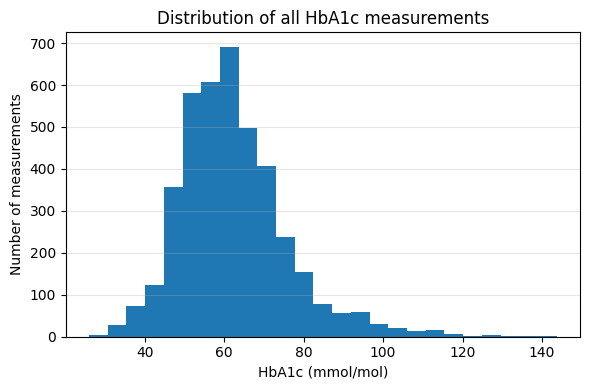

In [44]:
# %%
import matplotlib.pyplot as plt
import numpy as np

# ------------- ALL HbA1c MEASUREMENTS -------------
all_hba1c = df_sorted[HBA1C_COL].dropna()

print("\nHbA1c (all measurements) summary:")
print(all_hba1c.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round(2))

# HbA1c bands: ≤53, 53–64, ≥75 mmol/mol
hba1c_le_53 = (all_hba1c <= 53).sum()
hba1c_53_64 = ((all_hba1c > 53) & (all_hba1c <= 64)).sum()
hba1c_ge_75 = (all_hba1c >= 75).sum()

total = len(all_hba1c)
print("\nHbA1c bands (all rows):")
print(f"≤53 mmol/mol:   {hba1c_le_53} ({hba1c_le_53/total:.1%})")
print(f">53–64 mmol/mol: {hba1c_53_64} ({hba1c_53_64/total:.1%})")
print(f"≥75 mmol/mol:   {hba1c_ge_75} ({hba1c_ge_75/total:.1%})")

plt.figure(figsize=(6,4))
plt.hist(all_hba1c, bins=25)
plt.xlabel("HbA1c (mmol/mol)")
plt.ylabel("Number of measurements")
plt.title("Distribution of all HbA1c measurements")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()





eGFR (all measurements) summary:
count    4045.00
mean       81.28
std        17.27
min         4.00
5%         42.00
25%        78.00
50%        90.00
75%        90.00
95%        90.00
max       137.00
Name: LABmean__egfr_1_73m2_ckd_epi_ml_min, dtype: float64


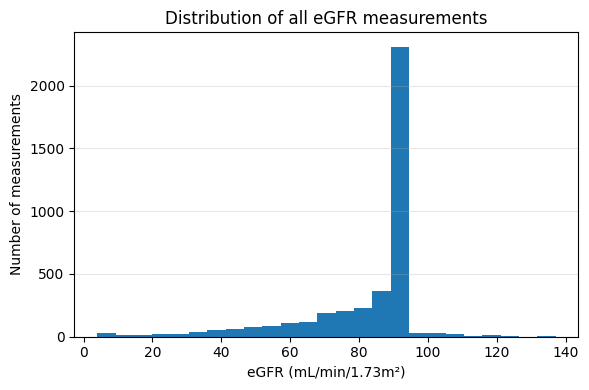


Patient-level average HbA1c & eGFR (each patient’s mean across visits):
       Mean HbA1c  Mean eGFR
count     1608.00    1607.00
mean        62.45      81.52
std         12.82      16.88
min         30.83       4.18
25%         54.00      78.04
50%         60.83      90.00
75%         68.67      90.00
max        123.33     134.00


In [45]:
# ------------- ALL eGFR MEASUREMENTS -------------
all_egfr = df_sorted[EGFR_COL].dropna()

print("\neGFR (all measurements) summary:")
print(all_egfr.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round(2))

plt.figure(figsize=(6,4))
plt.hist(all_egfr, bins=25)
plt.xlabel("eGFR (mL/min/1.73m²)")
plt.ylabel("Number of measurements")
plt.title("Distribution of all eGFR measurements")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: quick look at patient-level averages
per_patient_means = (
    df_sorted.groupby(ID_COL)[[HBA1C_COL, EGFR_COL]]
    .mean(numeric_only=True)
    .rename(columns={HBA1C_COL: "Mean HbA1c", EGFR_COL: "Mean eGFR"})
)

print("\nPatient-level average HbA1c & eGFR (each patient’s mean across visits):")
print(per_patient_means.describe().round(2))


Year-to-year pairs (patients with ≥2 screenings): 2541

HbA1c year-to-year change (mmol/mol) summary:
count    2430.00
mean       -1.05
std         9.67
min       -69.00
5%        -17.00
25%        -6.00
50%        -0.50
75%         4.00
95%        13.00
max        72.00
Name: HbA1c_change, dtype: float64


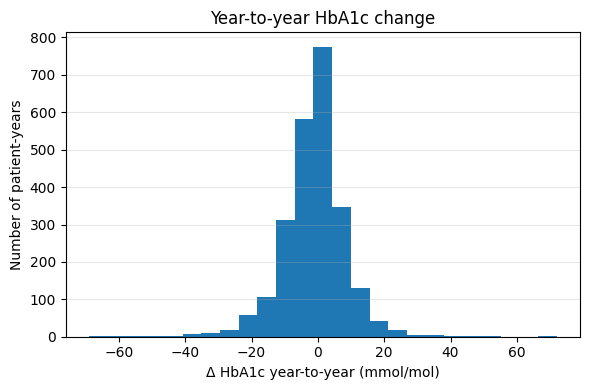


eGFR absolute year-to-year change (mL/min/1.73m²) summary:
count    2433.00
mean       -0.46
std         6.46
min       -43.25
5%        -11.50
25%        -1.20
50%         0.00
75%         0.00
95%         9.50
max        51.93
Name: eGFR_abs_change, dtype: float64

eGFR % year-to-year change summary:
count    2433.00
mean       -0.65
std        11.38
min       -62.20
5%        -17.01
25%        -1.67
50%         0.00
75%         0.00
95%        14.46
max       305.46
Name: eGFR_pct_change, dtype: float64


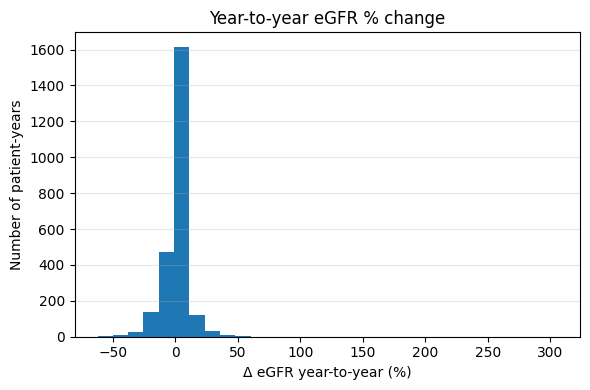

In [46]:
# ------------- YEAR-TO-YEAR CHANGES -------------
# Compute lagged values per patient
df_sorted["HbA1c_prev"] = df_sorted.groupby(ID_COL)[HBA1C_COL].shift(1)
df_sorted["eGFR_prev"]  = df_sorted.groupby(ID_COL)[EGFR_COL].shift(1)

# Only rows with a previous year available
chg = df_sorted.dropna(subset=["HbA1c_prev", "eGFR_prev"]).copy()

# HbA1c absolute change (mmol/mol)
chg["HbA1c_change"] = chg[HBA1C_COL] - chg["HbA1c_prev"]

# eGFR absolute and % change
chg["eGFR_abs_change"] = chg[EGFR_COL] - chg["eGFR_prev"]
chg["eGFR_pct_change"] = (chg["eGFR_abs_change"] / chg["eGFR_prev"]) * 100

print(f"\nYear-to-year pairs (patients with ≥2 screenings): {len(chg)}")

print("\nHbA1c year-to-year change (mmol/mol) summary:")
print(chg["HbA1c_change"].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).round(2))

plt.figure(figsize=(6,4))
plt.hist(chg["HbA1c_change"].dropna(), bins=25)
plt.xlabel("Δ HbA1c year-to-year (mmol/mol)")
plt.ylabel("Number of patient-years")
plt.title("Year-to-year HbA1c change")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\neGFR absolute year-to-year change (mL/min/1.73m²) summary:")
print(chg["eGFR_abs_change"].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).round(2))

print("\neGFR % year-to-year change summary:")
print(chg["eGFR_pct_change"].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).round(2))

plt.figure(figsize=(6,4))
plt.hist(chg["eGFR_pct_change"].dropna(), bins=30)
plt.xlabel("Δ eGFR year-to-year (%)")
plt.ylabel("Number of patient-years")
plt.title("Year-to-year eGFR % change")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()



In [47]:
# ------------- eGFR % CHANGE BANDS (5%-STEPS) -------------
# Bins: 5%-steps from -30% to +30%, with tails
bins = [-np.inf,
        -30, -25, -20, -15, -10, -5,
         0,
         5, 10, 15, 20, 25, 30,
         np.inf]

labels = [
    "<-30%",
    "-30 to -25%",
    "-25 to -20%",
    "-20 to -15%",
    "-15 to -10%",
    "-10 to -5%",
    "-5 to 0%",
    "0 to 5%",
    "5 to 10%",
    "10 to 15%",
    "15 to 20%",
    "20 to 25%",
    "25 to 30%",
    ">30%"
]

chg["eGFR_pct_band"] = pd.cut(chg["eGFR_pct_change"], bins=bins, labels=labels, right=True, include_lowest=True)
band_counts = chg["eGFR_pct_band"].value_counts().sort_index()

print("\neGFR % change bands (year-to-year):")
print(band_counts.to_frame("n").assign(pct=lambda x: (x["n"] / x["n"].sum() * 100).round(1)))


eGFR % change bands (year-to-year):
                  n   pct
eGFR_pct_band            
<-30%            30   1.2
-30 to -25%      15   0.6
-25 to -20%      46   1.9
-20 to -15%      56   2.3
-15 to -10%     123   5.1
-10 to -5%      182   7.5
-5 to 0%       1466  60.3
0 to 5%         208   8.5
5 to 10%        121   5.0
10 to 15%        72   3.0
15 to 20%        53   2.2
20 to 25%        20   0.8
25 to 30%        16   0.7
>30%             25   1.0


Dataset contains 4,168 rows and 1,608 unique patients.

=== VARIABLE COMPLETENESS OVERVIEW ===


,Variable,% Missing,Unique values,Mean,SD,Flag
0,DW_EK_Borger,0.000000,1608,668255.053000,374579.769000,Good (≥80% non-missing)
33,lab_window_n_rows,0.000000,35,2.540000,3.361000,Good (≥80% non-missing)
32,lab_window_end,0.000000,42,nan,nan,Non-numeric or categorical
31,lab_window_start,0.000000,42,nan,nan,Non-numeric or categorical
30,has_lab_in_window,0.000000,2,0.977000,0.151000,Good (≥80% non-missing)
26,has_who_in_window,0.000000,2,0.722000,0.448000,Good (≥80% non-missing)
24,anchor_first_time,0.000000,670,nan,nan,Non-numeric or categorical
23,n_anchor_bookings_that_day,0.000000,1,1.000000,0.000000,Good (≥80% non-missing)
22,visit_statuses,0.000000,377,nan,nan,Non-numeric or categorical
21,visit_topics,0.000000,2507,nan,nan,Non-numeric or categorical



=== COVERAGE BY CLINICAL GROUP ===

HbA1c: No columns found.

eGFR: No columns found.

Creatinine: No columns found.

Lipids: No columns found.

WHO-5: 1 col(s): ['who_score']
  → Patients with ≥1 value: 87.4%
  Flag: GOOD coverage

Albumin: No columns found.

Electrolytes: No columns found.

Vitamins: No columns found.

Hemoglobin: No columns found.


=== DISTRIBUTIONS FOR NUMERIC LAB VARIABLES ===


LABmean__b_haemoglobin_mmol_l — 3450 values
count    3450.00
mean        8.70
std         0.96
min         4.70
5%          7.02
25%         8.10
50%         8.74
75%         9.40
95%        10.10
max        12.30
Name: LABmean__b_haemoglobin_mmol_l, dtype: float64


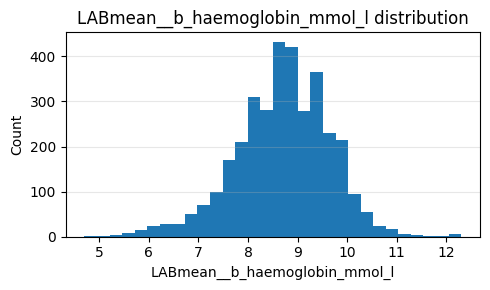


LABmean__egfr_1_73m2_ckd_epi_ml_min — 4045 values
count    4045.00
mean       81.28
std        17.27
min         4.00
5%         42.00
25%        78.00
50%        90.00
75%        90.00
95%        90.00
max       137.00
Name: LABmean__egfr_1_73m2_ckd_epi_ml_min, dtype: float64


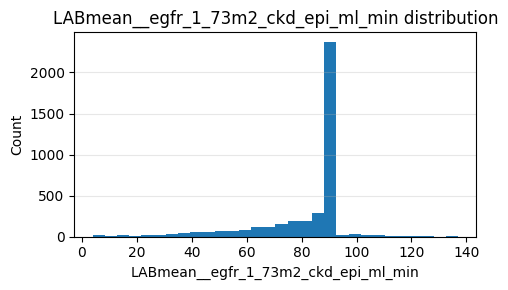


LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol — 4047 values
count    4047.00
mean       62.22
std        13.60
min        26.00
5%         44.00
25%        53.00
50%        60.00
75%        69.00
95%        88.00
max       143.67
Name: LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol, dtype: float64


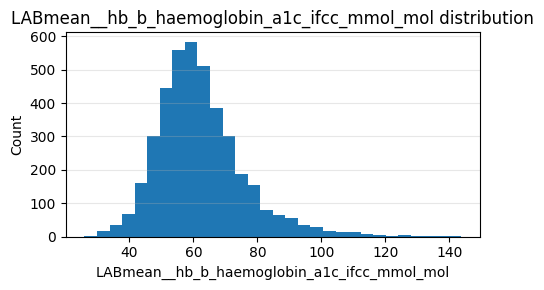


LABmean__p_25_hydroxy_vitamin_d_d3_d2_nmol_l — 741 values
count    741.00
mean      73.91
std       32.15
min       13.00
5%        25.00
25%       51.00
50%       73.00
75%       94.00
95%      127.00
max      275.00
Name: LABmean__p_25_hydroxy_vitamin_d_d3_d2_nmol_l, dtype: float64


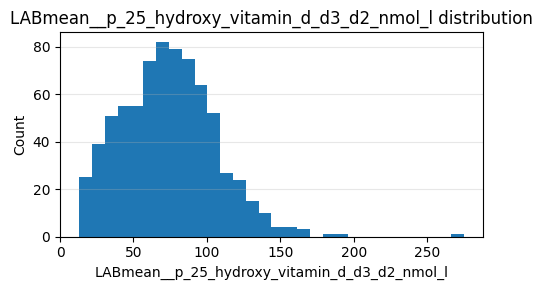


LABmean__p_albumin_g_l — 1049 values
count    1049.00
mean       38.39
std         4.59
min        17.62
5%         29.50
25%        36.00
50%        39.00
75%        41.00
95%        45.00
max        50.00
Name: LABmean__p_albumin_g_l, dtype: float64


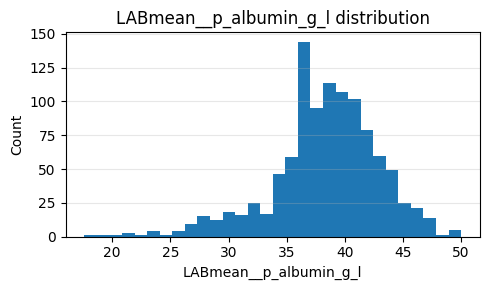


LABmean__p_calcium_albuminkorrigeret_mmol_l — 806 values
count    806.00
mean       2.37
std        0.10
min        1.98
5%         2.21
25%        2.30
50%        2.36
75%        2.44
95%        2.54
max        2.77
Name: LABmean__p_calcium_albuminkorrigeret_mmol_l, dtype: float64


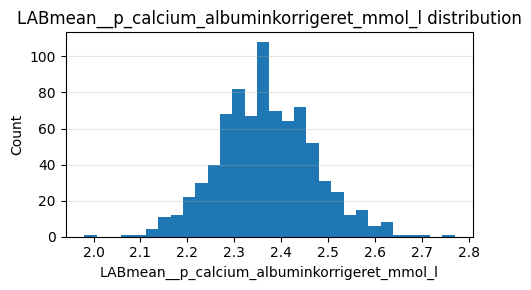


LABmean__p_calcium_mmol_l — 806 values
count    806.00
mean       2.34
std        0.12
min        1.94
5%         2.14
25%        2.27
50%        2.35
75%        2.42
95%        2.53
max        2.79
Name: LABmean__p_calcium_mmol_l, dtype: float64


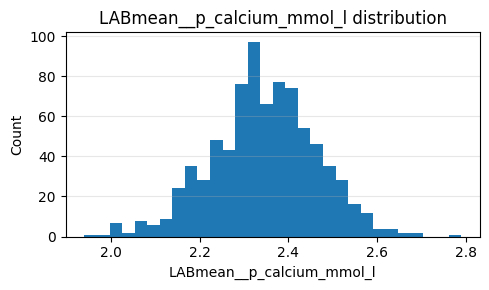


LABmean__p_kalium_mmol_l — 4029 values
count    4029.00
mean        4.05
std         0.35
min         2.60
5%          3.50
25%         3.80
50%         4.00
75%         4.30
95%         4.60
max         5.78
Name: LABmean__p_kalium_mmol_l, dtype: float64


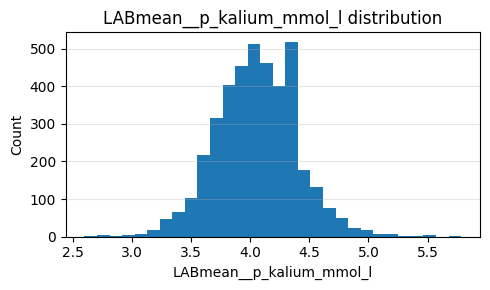


LABmean__p_kolesterol_hdl_mmol_l — 4003 values
count    4003.00
mean        1.44
std         0.42
min         0.44
5%          0.85
25%         1.10
50%         1.40
75%         1.70
95%         2.20
max         3.60
Name: LABmean__p_kolesterol_hdl_mmol_l, dtype: float64


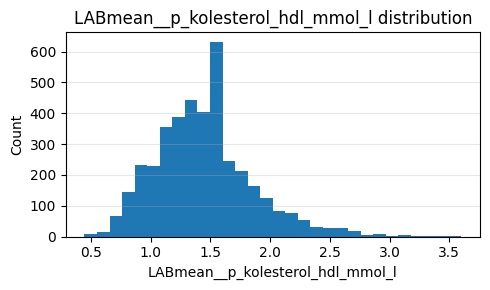


LABmean__p_kolesterol_ldl_mmol_l — 3926 values
count    3926.00
mean        2.32
std         0.77
min         0.10
5%          1.20
25%         1.80
50%         2.25
75%         2.79
95%         3.70
max         6.30
Name: LABmean__p_kolesterol_ldl_mmol_l, dtype: float64


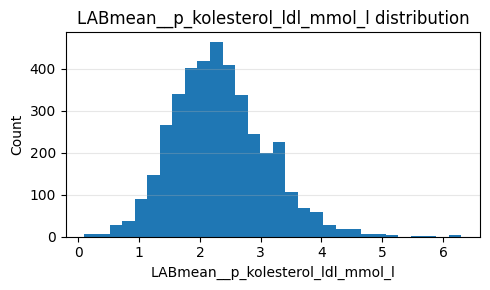


LABmean__p_kolesterol_mmol_l — 4004 values
count    4004.00
mean        4.33
std         0.92
min         1.75
5%          3.00
25%         3.70
50%         4.30
75%         4.90
95%         5.90
max         9.50
Name: LABmean__p_kolesterol_mmol_l, dtype: float64


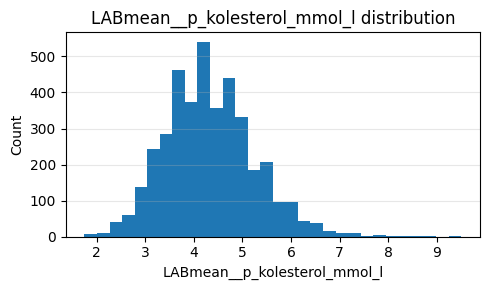


LABmean__p_kreatinin_umol_l — 4045 values
count    4045.00
mean       84.19
std        65.06
min        20.00
5%         51.00
25%        63.00
50%        73.00
75%        85.00
95%       134.73
max      1005.50
Name: LABmean__p_kreatinin_umol_l, dtype: float64


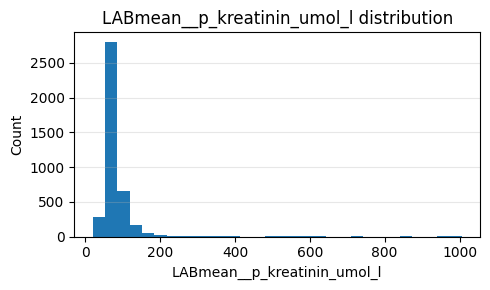


LABmean__p_natrium_mmol_l — 4033 values
count    4033.00
mean      139.24
std         2.47
min       127.00
5%        135.00
25%       138.00
50%       139.33
75%       141.00
95%       143.00
max       148.50
Name: LABmean__p_natrium_mmol_l, dtype: float64


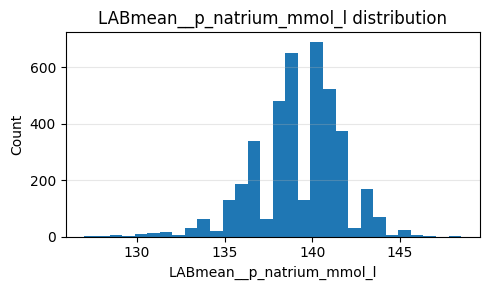


LABmean__p_triglycerid_mmol_l — 4004 values
count    4004.00
mean        1.35
std         1.51
min         0.20
5%          0.50
25%         0.70
50%         1.00
75%         1.55
95%         3.10
max        45.20
Name: LABmean__p_triglycerid_mmol_l, dtype: float64


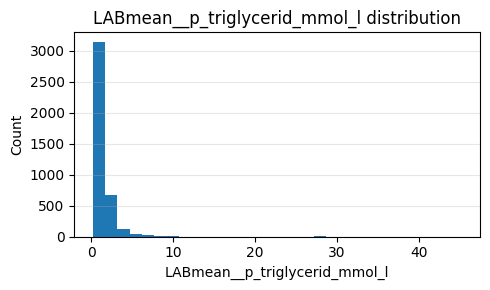


LABmean__p_vitamin_b12_pmol_l — 3988 values
count    3988.00
mean      402.19
std       188.52
min       109.00
5%        191.35
25%       278.00
50%       364.00
75%       478.00
95%       733.65
max      1476.00
Name: LABmean__p_vitamin_b12_pmol_l, dtype: float64


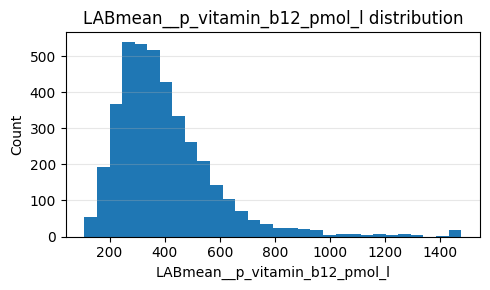


LABmean__u_albumin_kreatinin_ratio_mg_g — 3357 values
count     3357.00
mean       130.04
std        579.72
min          2.00
5%           4.00
25%          6.00
50%         12.00
75%         31.00
95%        502.15
max      11441.00
Name: LABmean__u_albumin_kreatinin_ratio_mg_g, dtype: float64


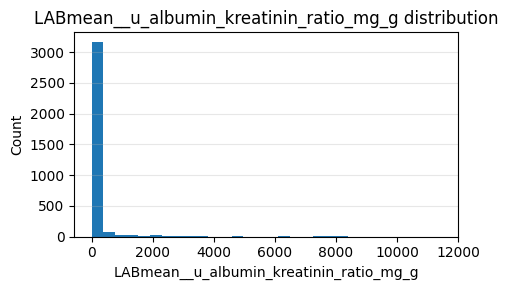


LABmean__u_albumin_kreatinin_ratio_x_10_3 — 276 values
count     276.00
mean      210.08
std       764.53
min         2.60
5%          3.78
25%         6.88
50%        17.65
75%        74.32
95%       917.70
max      6132.77
Name: LABmean__u_albumin_kreatinin_ratio_x_10_3, dtype: float64


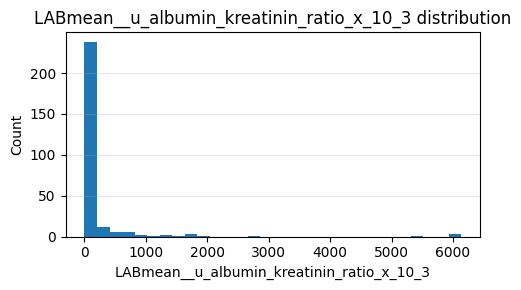


who_score — 3011 values
count    3011.00
mean       61.60
std        20.55
min         0.00
5%         20.00
25%        48.00
50%        68.00
75%        76.00
95%        88.00
max       100.00
Name: who_score, dtype: float64


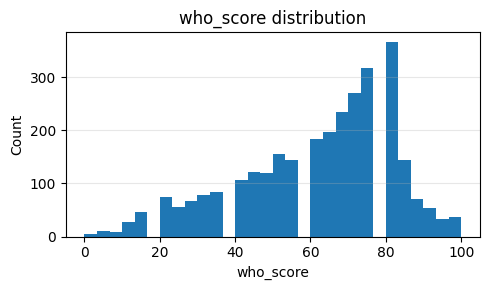


=== INTERPRETATION ===
1. Columns flagged 'Good' are ready for modelling.
2. 'Moderate' can be imputed (e.g., median or regression imputation).
3. 'Weak' should be excluded or used only in sensitivity tests.
4. Check WHO-5: if <60–70% coverage, include it only in a subset model.
5. If any lipid components are missing >40%, consider aggregating to a composite lipid ratio.


In [48]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure numeric for lab columns
lab_cols = [c for c in df.columns if c.startswith("LABmean__")]
df[lab_cols] = df[lab_cols].apply(pd.to_numeric, errors="coerce")

# ----------------------------------------
# CONFIG
# ----------------------------------------
ID_COL = "DW_EK_Borger"

# Key thematic groups (to interpret coverage)
key_groups = {
    "HbA1c": ["LABmean__Hb(B)-Hæmoglobin A1c (IFCC)_[mmol/mol]"],
    "eGFR": ["LABmean__eGFR / 1,73m²(CKD-EPI)_[ml/min]"],
    "Creatinine": ["LABmean__P-Kreatinin_[µmol/l]"],
    "Lipids": [
        "LABmean__P-Kolesterol_[mmol/l]",
        "LABmean__P-Kolesterol LDL_[mmol/l]",
        "LABmean__P-Kolesterol HDL_[mmol/l]",
        "LABmean__P-Triglycerid_[mmol/l]"
    ],
    "WHO-5": ["who_score"],
    "Albumin": [
        "LABmean__P-Albumin_[g/l]",
        "LABmean__U-Albumin / Kreatinin-ratio_[mg/g]"
    ],
    "Electrolytes": [
        "LABmean__P-Kalium_[mmol/l]",
        "LABmean__P-Natrium_[mmol/l]",
        "LABmean__P-Calcium (albuminkorrigeret)_[mmol/l]",
        "LABmean__P-Calcium_[mmol/l]"
    ],
    "Vitamins": [
        "LABmean__P-25-Hydroxy-Vitamin D(D3+D2)_[nmol/l]",
        "LABmean__P-Vitamin B12_[pmol/l]"
    ],
    "Hemoglobin": ["LABmean__B-Hæmoglobin_[mmol/l]"]
}

# ----------------------------------------
# DESCRIPTIVE SUMMARY
# ----------------------------------------
summary = []
n_rows = len(df)
n_patients = df[ID_COL].nunique()

print(f"Dataset contains {n_rows:,} rows and {n_patients:,} unique patients.\n")

for col in df.columns:
    miss_pct = df[col].isna().mean() * 100
    nunique = df[col].nunique(dropna=True)

    if pd.api.types.is_numeric_dtype(df[col]):
        mean = df[col].mean()
        std = df[col].std()
        flag = (
            "Good (≥80% non-missing)"
            if miss_pct <= 20 else
            "Moderate (20–50% missing)"
            if miss_pct <= 50 else
            "Weak (>50% missing)"
        )
    else:
        mean = np.nan
        std = np.nan
        flag = "Non-numeric or categorical"

    summary.append({
        "Variable": col,
        "% Missing": round(miss_pct, 1),
        "Unique values": nunique,
        "Mean": round(mean, 3) if not np.isnan(mean) else None,
        "SD": round(std, 3) if not np.isnan(std) else None,
        "Flag": flag
    })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values("% Missing", ascending=True)

print("=== VARIABLE COMPLETENESS OVERVIEW ===")
display(summary_df.style.background_gradient(subset=["% Missing"], cmap="Reds"))

# ----------------------------------------
# PER-GROUP COVERAGE
# ----------------------------------------
print("\n=== COVERAGE BY CLINICAL GROUP ===\n")

for group, cols in key_groups.items():
    existing = [c for c in cols if c in df.columns]
    if not existing:
        print(f"{group}: No columns found.\n")
        continue
    any_val = df[existing].notna().any(axis=1)
    patient_cov = 100 * df.loc[any_val, ID_COL].nunique() / n_patients
    print(f"{group}: {len(existing)} col(s): {existing}")
    print(f"  → Patients with ≥1 value: {patient_cov:.1f}%")
    if patient_cov >= 80:
        print("  Flag: GOOD coverage\n")
    elif patient_cov >= 50:
        print("  Flag: MODERATE coverage (imputation acceptable)\n")
    else:
        print("  Flag: WEAK coverage (consider dropping)\n")

# ----------------------------------------
# DISTRIBUTIONS FOR NUMERIC VARIABLES
# ----------------------------------------
print("\n=== DISTRIBUTIONS FOR NUMERIC LAB VARIABLES ===\n")

for col in lab_cols + ["who_score"]:
    if col not in df.columns:
        continue
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if len(s) < 10:
        continue

    print(f"\n{col} — {len(s)} values")
    print(s.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round(2))

    plt.figure(figsize=(5,3))
    plt.hist(s, bins=30)
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# ----------------------------------------
# SHORT INTERPRETATION
# ----------------------------------------
print("\n=== INTERPRETATION ===")
print("1. Columns flagged 'Good' are ready for modelling.")
print("2. 'Moderate' can be imputed (e.g., median or regression imputation).")
print("3. 'Weak' should be excluded or used only in sensitivity tests.")
print("4. Check WHO-5: if <60–70% coverage, include it only in a subset model.")
print("5. If any lipid components are missing >40%, consider aggregating to a composite lipid ratio.")


=== PATIENT GROUP SUMMARY ===
Total unique patients: 1,608
Patients with only one row: 0 (0.0%)
Patients with ≥2 rows: 1,608 (100.0%)

Distribution of number of rows per patient:
2    701
3    862
4     45
Name: count, dtype: int64


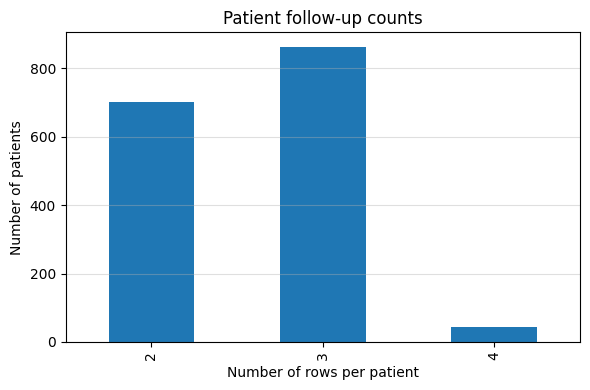


Multi-row dataset: 4,168 rows from 1,608 patients.
Single-row dataset: 0 rows from 0 patients.


In [49]:
# %%
import pandas as pd

ID_COL = "DW_EK_Borger"

# --- group counts ---
patient_counts = df.groupby(ID_COL).size()

n_total = patient_counts.shape[0]
n_single = (patient_counts == 1).sum()
n_multi = (patient_counts >= 2).sum()

print("=== PATIENT GROUP SUMMARY ===")
print(f"Total unique patients: {n_total:,}")
print(f"Patients with only one row: {n_single:,} ({n_single/n_total:.1%})")
print(f"Patients with ≥2 rows: {n_multi:,} ({n_multi/n_total:.1%})")

print("\nDistribution of number of rows per patient:")
print(patient_counts.value_counts().sort_index())

# --- visualize distribution ---
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
patient_counts.value_counts().sort_index().plot(kind="bar")
plt.xlabel("Number of rows per patient")
plt.ylabel("Number of patients")
plt.title("Patient follow-up counts")
plt.grid(axis="y", alpha=0.4)
plt.tight_layout()
plt.show()

# --- subset creation ---
df_multi = df[df[ID_COL].isin(patient_counts[patient_counts >= 2].index)].copy()
df_single = df[df[ID_COL].isin(patient_counts[patient_counts == 1].index)].copy()

print(f"\nMulti-row dataset: {df_multi.shape[0]:,} rows from {n_multi:,} patients.")
print(f"Single-row dataset: {df_single.shape[0]:,} rows from {n_single:,} patients.")


In [50]:
import pandas as pd

# --- Inputs ---
ID_COL = "DW_EK_Borger"
WHO_COL = "who_score"

# Load data
df = pd.read_excel(r"C:\Users\kfq6\Documents\Data\Sammedag_master_means.xlsx")


# --- Keep only patients with ≥2 rows (drop single-visit patients) ---
patient_counts = df.groupby(ID_COL).size()

multi_ids = patient_counts[patient_counts >= 2].index

print(f"\nKeeping only patients with ≥2 rows...")
print(f"Patients before filter: {patient_counts.shape[0]:,}")
print(f"Patients with ≥2 rows:  {len(multi_ids):,}")
print(f"Patients dropped (only 1 row): {(patient_counts.shape[0] - len(multi_ids)):,}")

# Overwrite df with multi-row cohort
df = df[df[ID_COL].isin(multi_ids)].copy()

print(f"\nFiltered dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Unique patients after filter: {df[ID_COL].nunique():,}")



# 1) Row-level flag: is WHO-5 missing on this row?
df["who_missing_row"] = df[WHO_COL].isna()

# 2) Patient-level: does the patient EVER have a WHO-5?
patient_has_any_who = (
    df.groupby(ID_COL)[WHO_COL]
      .apply(lambda x: x.notna().any())
      .rename("patient_has_any_who")
)

df = df.merge(patient_has_any_who, on=ID_COL)

# 3) Patient-level: is the patient NEVER having WHO-5 on ANY row?
df["patient_never_has_WHO"] = ~df["patient_has_any_who"]

# 4) Rows where WHO-5 is missing BUT patient has WHO-5 elsewhere
df["who_missing_in_partial_patient"] = (
    df["who_missing_row"] & df["patient_has_any_who"]
)



# --- Summaries ---

total_patients = df[ID_COL].nunique()
patients_never_who = (
    df.loc[df["patient_never_has_WHO"], ID_COL]
      .drop_duplicates()
)
patients_partial_who = (
    df.loc[df["who_missing_in_partial_patient"], ID_COL]
      .drop_duplicates()
)

print(f"Total patients: {total_patients}")
print(f"Patients with NO WHO-5 at all: {len(patients_never_who)}")
print(f"Patients with PARTIAL WHO-5 (some rows missing, some present): {len(patients_partial_who)}")

print("\nExample rows with missing WHO-5 in patients who have it elsewhere:")
print(
    df.loc[df["who_missing_in_partial_patient"],
           [ID_COL, "anchor_date", WHO_COL, "who_missing_row", "patient_has_any_who"]]
      .sort_values([ID_COL, "anchor_date"])
      .head(20)
)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\kfq6\\Documents\\Data\\Sammedag_master_means.xlsx'

In [ ]:
import pandas as pd

# === Inputs ===
LAB_PATH = r"C:\Users\kfq6\Documents\Data\LABKA.xlsx"  # <-- ret til korrekt filnavn
ID_COL = "DW_EK_Borger"

# Tjek at multi_ids findes fra din tidligere celle
try:
    multi_ids
except NameError:
    raise RuntimeError(
        "multi_ids er ikke defineret. Kør cellen med Sammedag_master_means-filtreringen først."
    )

# === 1. Indlæs originalt LAB-datasæt ===
labs = pd.read_excel(LAB_PATH)

# Sikr at dato-kolonnen er i datetime-format
labs["Dato_Proevetagningstid"] = pd.to_datetime(
    labs["Dato_Proevetagningstid"], errors="coerce"
)

# Smid rækker uden gyldig prøvedato
labs = labs[~labs["Dato_Proevetagningstid"].isna()].copy()

# Tilføj år
labs["year"] = labs["Dato_Proevetagningstid"].dt.year

# Begræns til 2022 og frem
labs = labs[labs["year"] >= 2022].copy()

# === 2. Begræns til inkluderede patienter (kun dem med ≥2 sammedagsscreeninger) ===
labs = labs[labs[ID_COL].isin(multi_ids)].copy()

print(f"Antal inkluderede patienter i LAB-datasættet: {labs[ID_COL].nunique()}")
print(f"Antal LAB-rækker (tests) fra 2022+: {len(labs):,}")

# === 3. Beregn antal prøver per patient per år ===
per_patient_year = (
    labs
    .groupby([ID_COL, "year"])
    .agg(
        n_tests_total=("Analysenavn", "size"),              # alle rækker = alle prøvesvar
        n_unique_analyses=("Analysenavn", "nunique"),       # forskellige analysetyper
        n_unique_test_dates=("Dato_Proevetagningstid", "nunique")  # hvor mange datoer
    )
    .reset_index()
)

print("\nEksempel på patient-år niveau (top 10 rækker):")
print(per_patient_year.head(10))

# === 4. Årsoversigt for hele kohorten ===
year_summary = (
    per_patient_year
    .groupby("year")
    .agg(
        n_patients=("DW_EK_Borger", "nunique"),
        mean_tests_per_patient=("n_tests_total", "mean"),
        median_tests_per_patient=("n_tests_total", "median"),
        mean_unique_analyses=("n_unique_analyses", "mean"),
        median_unique_analyses=("n_unique_analyses", "median"),
    )
    .reset_index()
)

print("\nÅrsoversigt for inkluderede patienter (2022+):")
print(year_summary.to_string(index=False))


c:\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Antal inkluderede patienter i LAB-datasættet: 1608
Antal LAB-rækker (tests) fra 2022+: 197,857

Eksempel på patient-år niveau (top 10 rækker):
   DW_EK_Borger  year  n_tests_total  n_unique_analyses  n_unique_test_dates
0          2822  2022              1                  1                    1
1          2822  2023             25                 13                    3
2          2822  2025             12                 12                    1
3          2897  2022             65                 15                    7
4          2897  2023             22                  9                    3
5          2897  2024             49                 15                    5
6          2897  2025             43                 15                    3
7          4001  2022             41                 13                    5
8          4001  2023             62                 15                    9
9          4001  2024            401                 15                   56

Årsoversi